# DS605 — LAB 4: Data Preprocessing and Regression With Scikit-learn




In [2]:
!pip install scikit-learn



  Using cached scikit_learn-1.7.1-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.1-cp311-cp311-win_amd64.whl (8.9 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
 

In [ ]:
# === Imports & Configuration ===
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Path to data
DATA_PATH = "D:\\ML Lab\\data-preprocessing-and-regression-with-scikit-learn-Kunal-Pramanik\\kc_house_data.csv"  


## Task 0: Load Data

In [5]:
# Load the dataset
df = pd.read_csv(r'D:\ML Lab\data-preprocessing-and-regression-with-scikit-learn-Kunal-Pramanik\kc_house_data.csv.csv')
print('Shape:', df.shape)
df.head()


Shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Task 1: Advanced EDA & Feature Engineering

### 1A) Simulate Missing Data (~5% in sqft_lot and bathrooms)
The original dataset is clean. To simulate real-world conditions, we randomly introduce ~5% missing values in the specified columns. Imputation will be handled later by the pipeline.

In [6]:
def inject_missing_values(data, columns, frac=0.05, random_state=RANDOM_STATE):
    data = data.copy()
    rng = np.random.default_rng(random_state)
    for col in columns:
        n = len(data)
        k = int(np.floor(frac * n))
        idx = rng.choice(n, size=k, replace=False)
        data.loc[idx, col] = np.nan
        print(f"Injected {k} NaNs into '{col}'")
    return data

df_missing = inject_missing_values(df, columns=['sqft_lot', 'bathrooms'], frac=0.05)
df_missing[['sqft_lot', 'bathrooms']].isna().mean().rename(lambda c: f'NaN rate in {c}')


Injected 1080 NaNs into 'sqft_lot'
Injected 1080 NaNs into 'bathrooms'


NaN rate in sqft_lot     0.04997
NaN rate in bathrooms    0.04997
dtype: float64

### 1B) Outlier Detection & Handling
We create boxplots for `price`, `sqft_living`, and `bedrooms`. We then remove egregious outliers using the **1.5 × IQR rule** (values beyond Q1 - 1.5×IQR or Q3 + 1.5×IQR).  
This is a standard, defensible rule to remove extreme values (e.g., a house with 33 bedrooms).

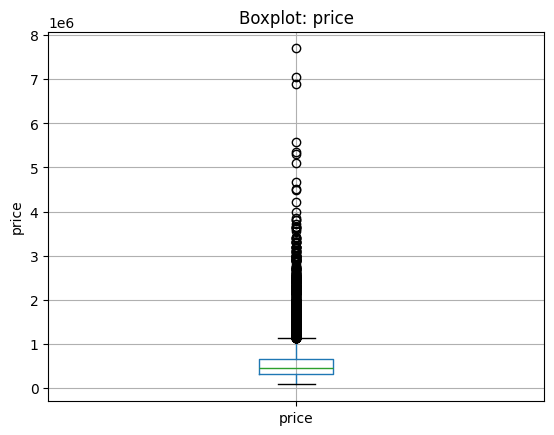

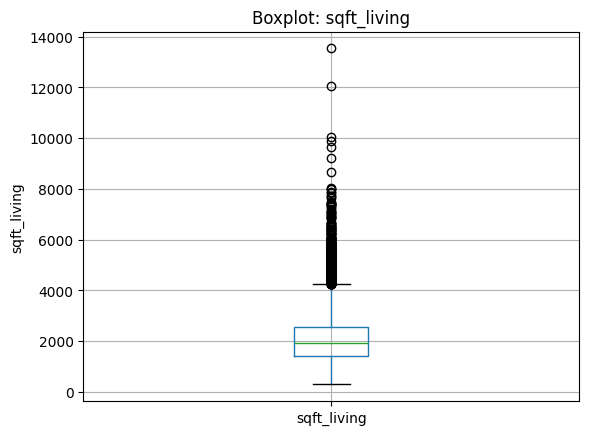

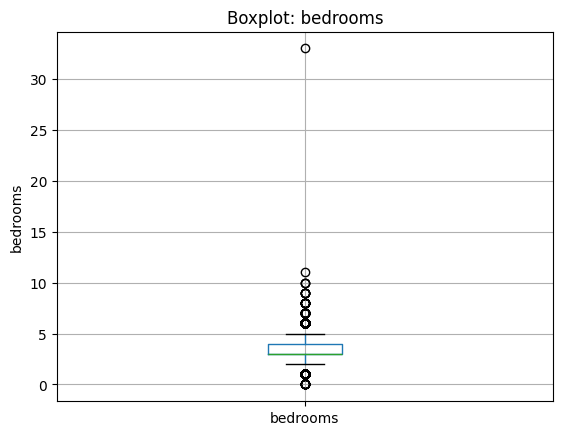

Outlier filtering with 1.5*IQR on ['price', 'sqft_living', 'bedrooms']: removed 1788 rows (8.27%).


(19825, 21)

In [7]:
features_for_boxplot = ['price', 'sqft_living', 'bedrooms']
for col in features_for_boxplot:
    plt.figure()
    df_missing.boxplot(column=col)
    plt.title(f'Boxplot: {col}')
    plt.ylabel(col)
    plt.show()

def iqr_filter(data, cols):
    """Remove rows where any of the `cols` is an outlier by 1.5*IQR rule."""
    data = data.copy()
    mask = pd.Series([True] * len(data), index=data.index)
    for c in cols:
        s = data[c].dropna()
        Q1, Q3 = s.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask &= (data[c].isna() | ((data[c] >= lower) & (data[c] <= upper)))
    before = len(data)
    data = data[mask].copy()
    after = len(data)
    print(f'Outlier filtering with 1.5*IQR on {cols}: removed {before - after} rows ({(before-after)/before:.2%}).')
    return data

df_clean = iqr_filter(df_missing, ['price', 'sqft_living', 'bedrooms'])
df_clean.shape


### 1C) Advanced Feature Engineering



In [8]:
fe = df_clean.copy()

# Ensure datetime
fe['date'] = pd.to_datetime(fe['date'], errors='coerce')

# Date-based features
fe['sale_year'] = fe['date'].dt.year
fe['sale_month'] = fe['date'].dt.month
fe['house_age'] = fe['sale_year'] - fe['yr_built']

# Renovation features
fe['was_renovated'] = (fe['yr_renovated'].fillna(0) > 0).astype(int)

# age_since_renovation: if never renovated, equal to house_age; else years since renovation
yr_ren = fe['yr_renovated'].fillna(0).astype(int)
fe['age_since_renovation'] = np.where(
    yr_ren > 0,
    fe['sale_year'] - yr_ren,
    fe['house_age']
)

# Ratio features with safe division
def safe_divide(a, b):
    return np.where(b == 0, np.nan, a / b)

fe['sqft_living_per_floor'] = safe_divide(fe['sqft_living'], fe['floors'].replace(0, np.nan))
fe['bath_per_bed'] = safe_divide(fe['bathrooms'], fe['bedrooms'].replace(0, np.nan))

TARGET = 'price'
print('Engineered columns added:', ['sale_year','sale_month','house_age','was_renovated','age_since_renovation','sqft_living_per_floor','bath_per_bed'])
fe.head()


Engineered columns added: ['sale_year', 'sale_month', 'house_age', 'was_renovated', 'age_since_renovation', 'sqft_living_per_floor', 'bath_per_bed']


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,sale_year,sale_month,house_age,was_renovated,age_since_renovation,sqft_living_per_floor,bath_per_bed
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650.0,1.0,0,0,...,-122.257,1340,5650,2014,10,59,0,59,1180.0,0.333333
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242.0,2.0,0,0,...,-122.319,1690,7639,2014,12,63,1,23,1285.0,0.750000
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000.0,1.0,0,0,...,-122.233,2720,8062,2015,2,82,0,82,770.0,0.500000
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000.0,1.0,0,0,...,-122.393,1360,5000,2014,12,49,0,49,1960.0,0.750000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080.0,1.0,0,0,...,-122.045,1800,7503,2015,2,28,0,28,1680.0,0.666667


### 1D) Define Feature Groups
We categorize columns after feature engineering into:
- **Numerical:** continuous variables needing imputation + scaling  
- **Categorical:** `zipcode` (one-hot with `handle_unknown='ignore'`)  
- **Passthrough:** ordinal/binary or already-scaled-like features that we don't want to scale/encode (e.g., `grade`, `condition`, `was_renovated`)

In [9]:
# Drop ID-like columns that shouldn't be predictive
drop_cols = ['id'] if 'id' in fe.columns else []

numeric_base = [
    'sqft_living','sqft_lot','bedrooms','bathrooms','floors',
    'sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15',
    'house_age','age_since_renovation','sqft_living_per_floor','bath_per_bed'
]
numeric_features = [c for c in numeric_base if c in fe.columns]
categorical_features = [c for c in ['zipcode'] if c in fe.columns]
passthrough_features = [c for c in ['grade','condition','waterfront','view','was_renovated','sale_year','sale_month'] if c in fe.columns]

all_features = numeric_features + categorical_features + passthrough_features
print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)
print('Passthrough features:', passthrough_features)

data = fe.drop(columns=drop_cols, errors='ignore').copy()
X = data[all_features].copy()
y = data[TARGET].copy()

X.shape, y.shape


Numeric features: ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'house_age', 'age_since_renovation', 'sqft_living_per_floor', 'bath_per_bed']
Categorical features: ['zipcode']
Passthrough features: ['grade', 'condition', 'waterfront', 'view', 'was_renovated', 'sale_year', 'sale_month']


((19825, 23), (19825,))

## Task 2: Sophisticated Preprocessing Pipeline
Train–test split, then define separate pipelines for numeric, categorical, and passthrough groups and combine with `ColumnTransformer`.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

passthrough_pipeline = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('pass', passthrough_pipeline, passthrough_features)
    ]
)
preprocessor


,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [11]:
def get_preprocessed_feature_names(preprocessor):
    feature_names = []
    # numeric
    num_features = preprocessor.transformers_[0][2]
    feature_names += list(num_features)
    # categorical
    cat_features = preprocessor.transformers_[1][2] if len(preprocessor.transformers_)>1 else []
    cat_transformer = preprocessor.named_transformers_.get('cat', None)
    if cat_transformer is not None and hasattr(cat_transformer.named_steps['onehot'], 'get_feature_names_out'):
        ohe = cat_transformer.named_steps['onehot']
        ohe_names = list(ohe.get_feature_names_out(cat_features))
        feature_names += ohe_names
    else:
        feature_names += list(cat_features)
    # passthrough
    pass_features = preprocessor.transformers_[2][2] if len(preprocessor.transformers_)>2 else []
    feature_names += list(pass_features)
    return feature_names


## Task 3: Model Training and Hyperparameter Tuning

Before tuning, we’ll fit a simple **baseline Linear Regression** on the preprocessed data (helps with later comparison).

In [13]:
!pip install -U scikit-learn


In [19]:
baseline_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
baseline_pipe.fit(X_train, y_train)

y_pred_base = baseline_pipe.predict(X_test)
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
base_mae = mean_absolute_error(y_test, y_pred_base)
base_r2 = r2_score(y_test, y_pred_base)

print(f'Baseline LinearRegression -> RMSE: {base_rmse:,.2f} | MAE: {base_mae:,.2f} | R2: {base_r2:.4f}')


Baseline LinearRegression -> RMSE: 81,853.00 | MAE: 59,084.05 | R2: 0.8378


### 3A) Candidate Models
We consider **Random Forest**, **Gradient Boosting**, and (optionally) **XGBoost**. Each is wrapped in a pipeline with the `preprocessor`.

In [20]:
models = []
# Random Forest
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor(random_state=42))])
rf_grid = {
    'regressor__n_estimators': [200, 400],
    'regressor__max_depth': [None, 10, 20]
}
models.append(('RandomForest', rf_pipe, rf_grid))

# Gradient Boosting
gb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', GradientBoostingRegressor(random_state=42))])
gb_grid = {
    'regressor__n_estimators': [200, 400],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [2, 3]
}
models.append(('GradientBoosting', gb_pipe, gb_grid))

# XGBoost (optional)
if XGB_AVAILABLE:
    xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1))])
    xgb_grid = {
        'regressor__n_estimators': [300, 600],
        'regressor__max_depth': [4, 6],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__subsample': [0.8, 1.0],
        'regressor__colsample_bytree': [0.8, 1.0]
    }
    models.append(('XGBoost', xgb_pipe, xgb_grid))
else:
    print('XGBoost not installed; skipping XGBoost model.')


### 3B) Grid Search (cv=3)
We perform 3-fold cross-validation for each model to find the best hyperparameters.

In [21]:
search_results = {}

for name, pipe, grid in models:
    print(f"\n=== GridSearchCV for {name} ===")
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring='neg_root_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    best_rmse = -gs.best_score_
    search_results[name] = {
        'grid': gs,
        'best_params': gs.best_params_,
        'cv_best_rmse': best_rmse
    }
    print(f'Best CV RMSE for {name}: {best_rmse:,.2f}')
    print('Best Params:', gs.best_params_)

best_name = min(search_results.keys(), key=lambda k: search_results[k]['cv_best_rmse'])
best_grid = search_results[best_name]['grid']
best_params = search_results[best_name]['best_params']
print(f"\n>>> Best overall model by CV RMSE: {best_name}")
print('Best Params:', best_params)



=== GridSearchCV for RandomForest ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best CV RMSE for RandomForest: 77,313.49
Best Params: {'regressor__max_depth': None, 'regressor__n_estimators': 400}

=== GridSearchCV for GradientBoosting ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best CV RMSE for GradientBoosting: 73,750.56
Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 400}

=== GridSearchCV for XGBoost ===
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best CV RMSE for XGBoost: 70,415.86
Best Params: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__n_estimators': 600, 'regressor__subsample': 0.8}

>>> Best overall model by CV RMSE: XGBoost
Best Params: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__n_estimators': 600, 'regressor__subsample': 0.8}


## Task 4: Evaluation & Interpretation

### 4A) Final Evaluation on Test Set
We evaluate the **best tuned pipeline** on the held-out test set and report R², MAE, and RMSE.

In [22]:
best_model = best_grid.best_estimator_
y_pred = best_model.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f'Best Model: {best_name}')
print(f'Test RMSE: {final_rmse:,.2f}')
print(f'Test MAE: {final_mae:,.2f}')
print(f'Test R2 : {final_r2:.4f}')


Best Model: XGBoost
Test RMSE: 68,272.66
Test MAE: 46,469.90
Test R2 : 0.8872


### 4B) Performance Comparison


,RMSE
Tuned_XGBoost_RMSE,68272.661293
Baseline_LinearRegression_RMSE,81853.003061


<Figure size 640x480 with 0 Axes>

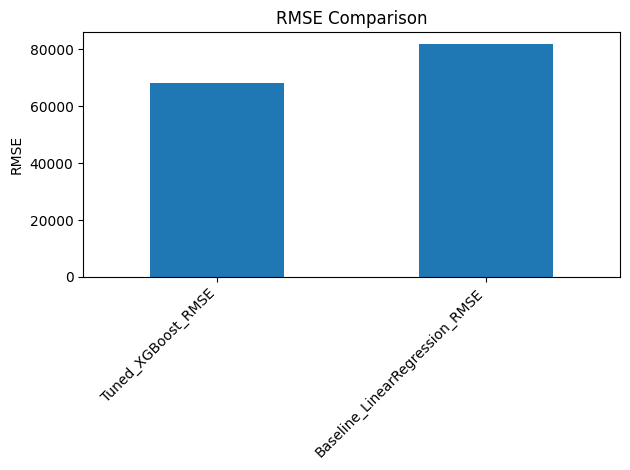

Improvement vs Baseline LinearRegression: 16.59%


In [23]:
original_best_rmse = None  # e.g., 150000.0

compare = {
    'Baseline_LinearRegression_RMSE': base_rmse,
    f'Tuned_{best_name}_RMSE': final_rmse
}
if original_best_rmse is not None:
    compare['Original_Notebook_Best_RMSE'] = float(original_best_rmse)

cmp_df = pd.DataFrame.from_dict(compare, orient='index', columns=['RMSE']).sort_values('RMSE')
display(cmp_df)

plt.figure()
cmp_df.plot(kind='bar', legend=False)
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

if original_best_rmse is not None:
    improvement = 100.0 * (original_best_rmse - final_rmse) / original_best_rmse
    print(f'Improvement vs Original Notebook Best RMSE: {improvement:.2f}%')
else:
    improvement = 100.0 * (base_rmse - final_rmse) / base_rmse
    print(f'Improvement vs Baseline LinearRegression: {improvement:.2f}%')


### 4C) Feature Importance (Tree-Based Models)
If the best model is tree-based (RandomForest, GradientBoosting, XGBoost), we extract feature importances and plot the **Top 20**.  
For models without `feature_importances_`, this section will skip automatically.

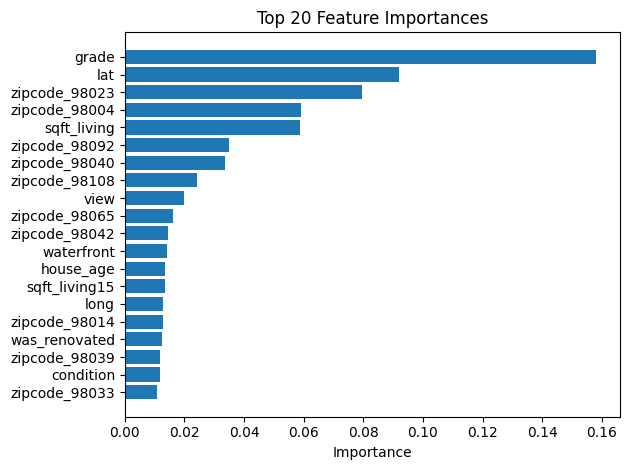

,feature,importance_score
85,grade,0.158181
7,lat,0.091976
28,zipcode_98023,0.079386
18,zipcode_98004,0.059045
0,sqft_living,0.058657


In [24]:
def plot_feature_importance(model, preprocessor, top_n=20):
    if not hasattr(model, 'feature_importances_'):
        print('This model does not provide feature_importances_. Skipping.')
        return
    names = get_preprocessed_feature_names(preprocessor)
    importances = model.feature_importances_
    n = min(len(names), len(importances))
    fi = pd.DataFrame({'feature': names[:n], 'importance': importances[:n]})
    fi = fi.sort_values('importance', ascending=False).head(top_n)
    plt.figure()
    plt.barh(fi['feature'][::-1], fi['importance'][::-1])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()
    return fi

tree_model = getattr(best_model, 'named_steps', {}).get('regressor', None)
if tree_model is None:
    tree_model = best_model if hasattr(best_model, 'feature_importances_') else None

if tree_model is not None and hasattr(tree_model, 'feature_importances_'):
    top_fi = plot_feature_importance(tree_model, best_model.named_steps['preprocessor'], top_n=20)
    if top_fi is not None:
        display(top_fi.head(5).rename(columns={'importance':'importance_score'}))
else:
    print('Best model is not a tree-based model with feature_importances_.')


## 4D)Summary:
- **Best model:** *XGBoost*  
- **Top 5 features:** --grade,lat,zipcode_98023,zipcode_98004,sqft_living 
                      --so there are no Engineered feature .
